### Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy

### Load Data

In [ ]:
data20 = pd.read_csv('data/om-2020.csv', delimiter=",", skiprows=3)
data21 = pd.read_csv('data/om-2021.csv', delimiter=",", skiprows=3 )
data22 = pd.read_csv('data/om-2022.csv', delimiter=",", skiprows=3)
data23 = pd.read_csv('data/om-2023.csv', delimiter=",", skiprows=3)
data24 = pd.read_csv('data/om-2024.csv', delimiter=",", skiprows=3)

data_raw = pd.read_csv('data/data-2010-2024.csv', delimiter=",", skiprows=3)
data_test = pd.read_csv('data/om-2025jan-test.csv', delimiter="," )

In [70]:
print(data_raw)

                    time  temperature_2m (°C)  precipitation (mm)  \
0       2010-01-01T00:00                 -0.8                 0.0   
1       2010-01-01T01:00                 -0.8                 0.0   
2       2010-01-01T02:00                 -0.8                 0.0   
3       2010-01-01T03:00                 -0.9                 0.0   
4       2010-01-01T04:00                 -0.9                 0.0   
...                  ...                  ...                 ...   
131491  2024-12-31T19:00                  3.9                 0.0   
131492  2024-12-31T20:00                  4.9                 0.0   
131493  2024-12-31T21:00                  5.4                 0.0   
131494  2024-12-31T22:00                  5.8                 0.0   
131495  2024-12-31T23:00                  6.4                 0.0   

        weather_code (wmo code)  cloud_cover (%)  wind_speed_10m (km/h)  \
0                            71              100                   14.8   
1                    

### Functions 

In [5]:
weather_columns = {
    'temperature_2m (°C)': 'temp',
    'weather_code (wmo code)': 'weather_code',
    'precipitation (mm)': 'precip',
    'cloud_cover (%)': 'cloud_cover',
    'wind_speed_10m (km/h)': 'wind_speed',
    'sunshine_duration (s)': 'sunshine',    
}



In [6]:
def add_time_columns(df):
    constant_year = 2000
    df['time'] = pd.to_datetime(df['time'])
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['year'] = df['time'].dt.year
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    df['hour'] = df['time'].dt.hour
    df['month_day_time'] = pd.to_datetime(
        df['month'].astype(str) + '-' +
        df['day'].astype(str) + '-' +
        str(constant_year) + ' ' +
        df['hour'].astype(str).str.zfill(2) + ':' +
        df['minute'].astype(str).str.zfill(2) + ':' +
        df['second'].astype(str).str.zfill(2),  format='%m-%d-%Y %H:%M:%S')
    return df

def rename_columns(df):
    df.rename(columns=weather_columns, inplace=True)
    return df



In [7]:
all_data = add_time_columns(data_raw)
all_data = rename_columns(all_data)

In [8]:
all_data.columns

Index(['time', 'temp', 'precip', 'weather_code', 'cloud_cover', 'wind_speed',
       'sunshine', 'month', 'day', 'year', 'minute', 'second', 'hour',
       'month_day_time'],
      dtype='object')

In [9]:
# checking for null values
all_data.isnull().values.any()

np.False_

### Data Overview - weather variables distribution

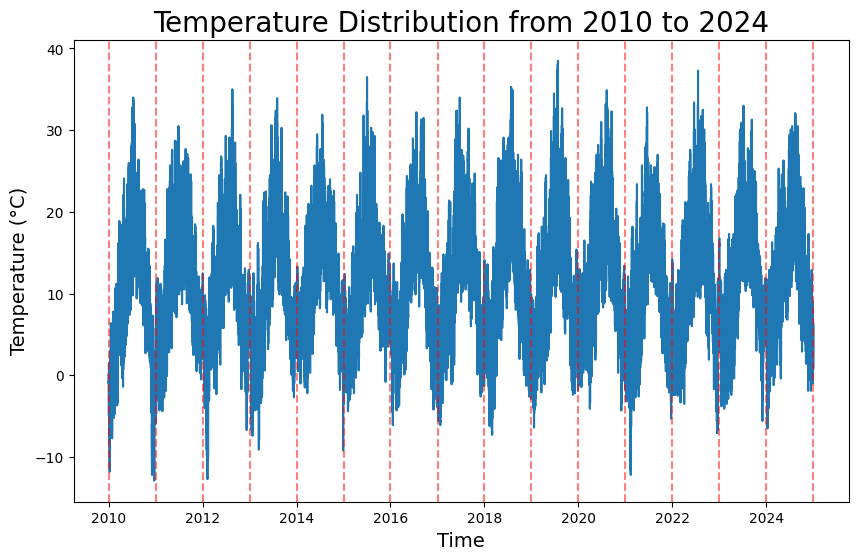

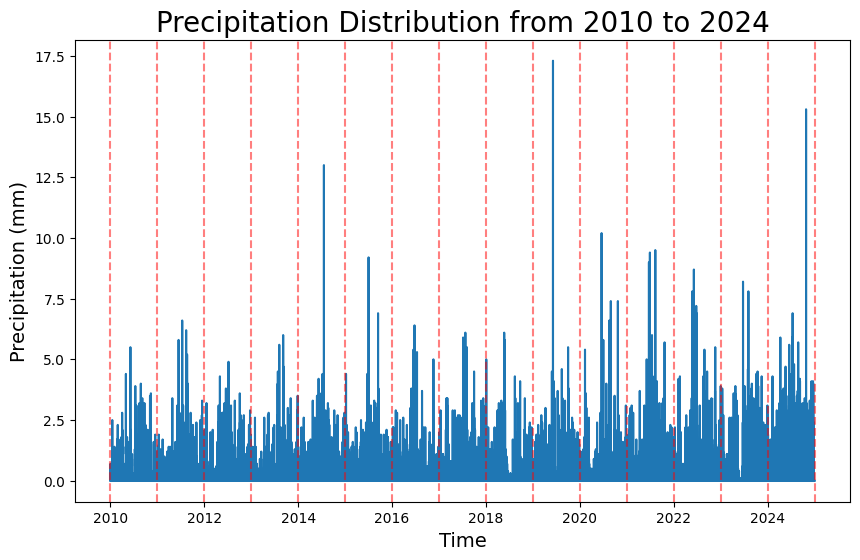

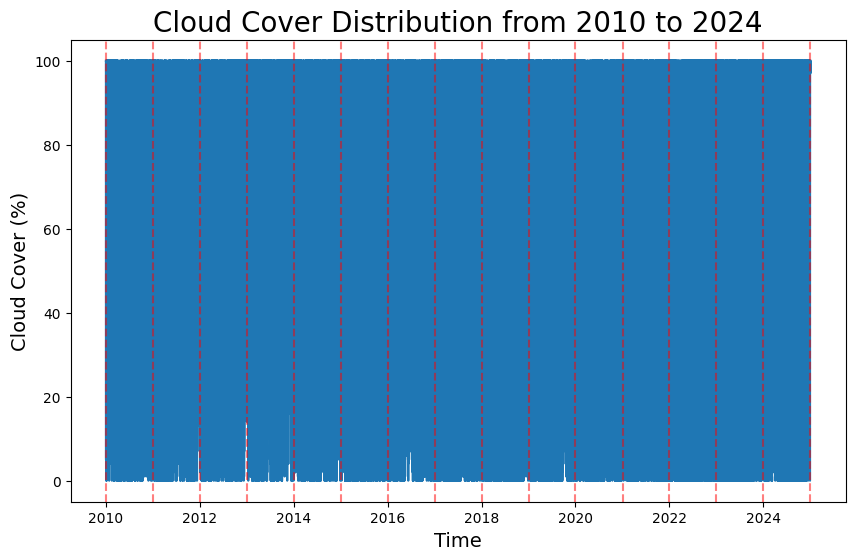

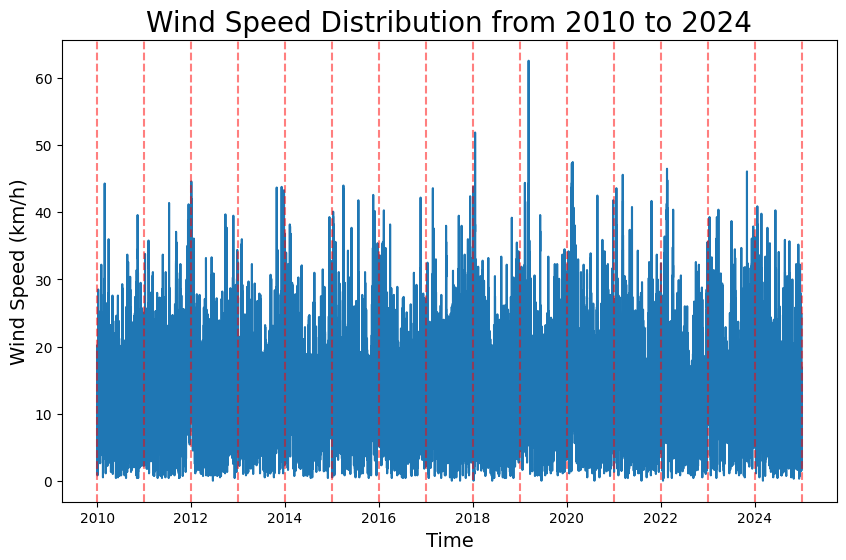

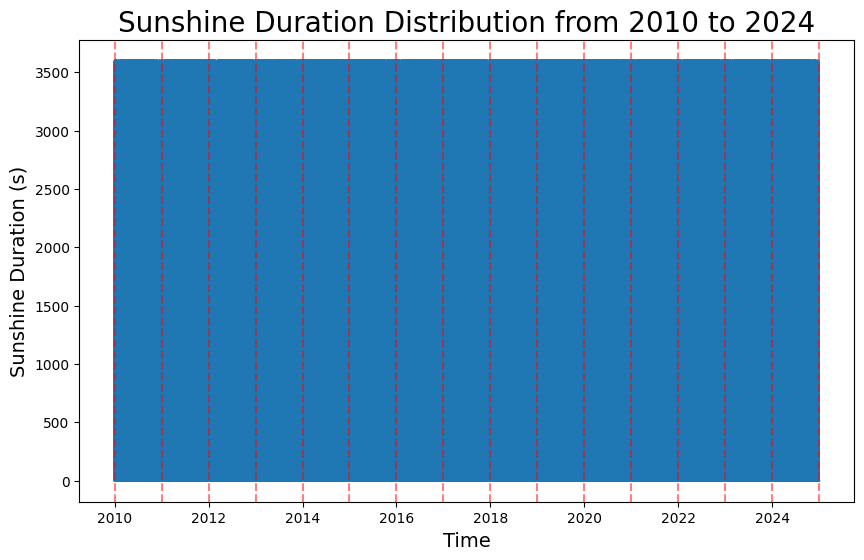

In [10]:
def plot_weather_distribution(weather_var, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(all_data['time'], all_data[weather_var])
    plt.xlabel('Time', size=14)
    plt.ylabel(ylabel, size=14)
    plt.title(title, size=20)
    # add lines for each year
    for year in range(2010, 2026):
        plt.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', alpha=0.5)

    plt.show()

plot_weather_distribution('temp', title = 'Temperature Distribution from 2010 to 2024', ylabel = 'Temperature (°C)')
plot_weather_distribution('precip', title = 'Precipitation Distribution from 2010 to 2024', ylabel = 'Precipitation (mm)')
plot_weather_distribution('cloud_cover', title = 'Cloud Cover Distribution from 2010 to 2024', ylabel = 'Cloud Cover (%)')
plot_weather_distribution('wind_speed', title = 'Wind Speed Distribution from 2010 to 2024', ylabel = 'Wind Speed (km/h)')   
plot_weather_distribution('sunshine', title = 'Sunshine Duration Distribution from 2010 to 2024', ylabel = 'Sunshine Duration (s)')




### Average of Weather Variables Data Overview

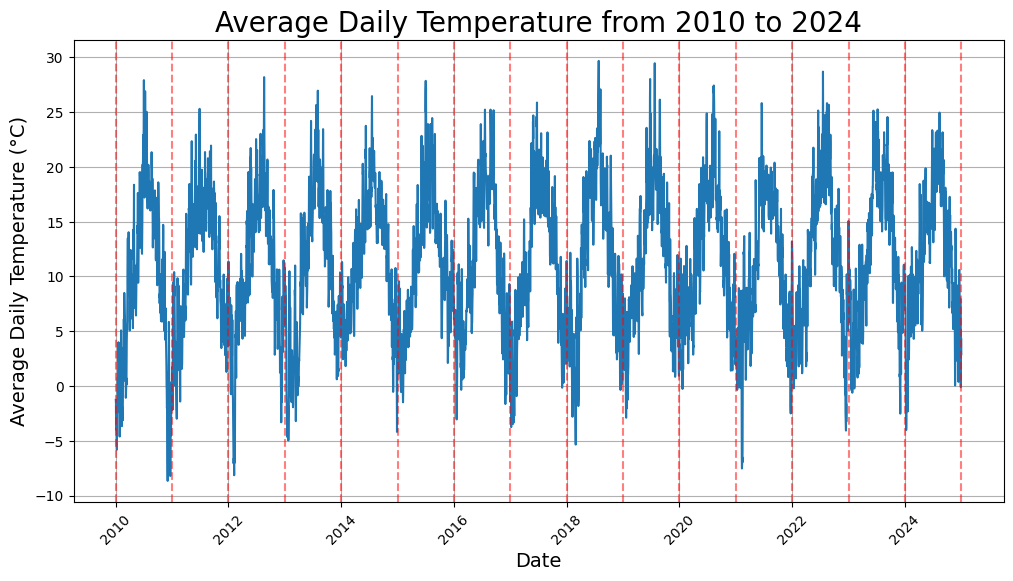

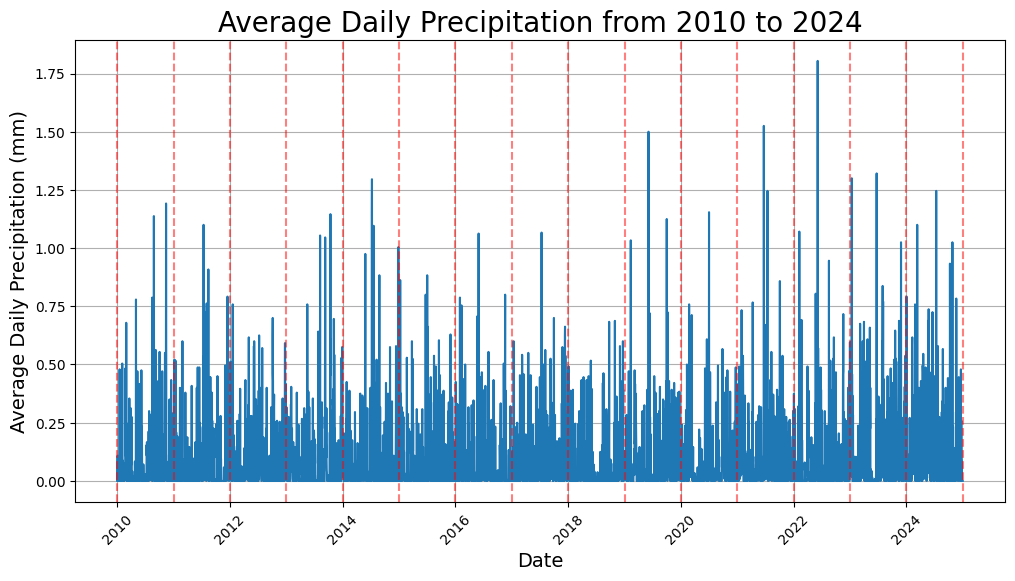

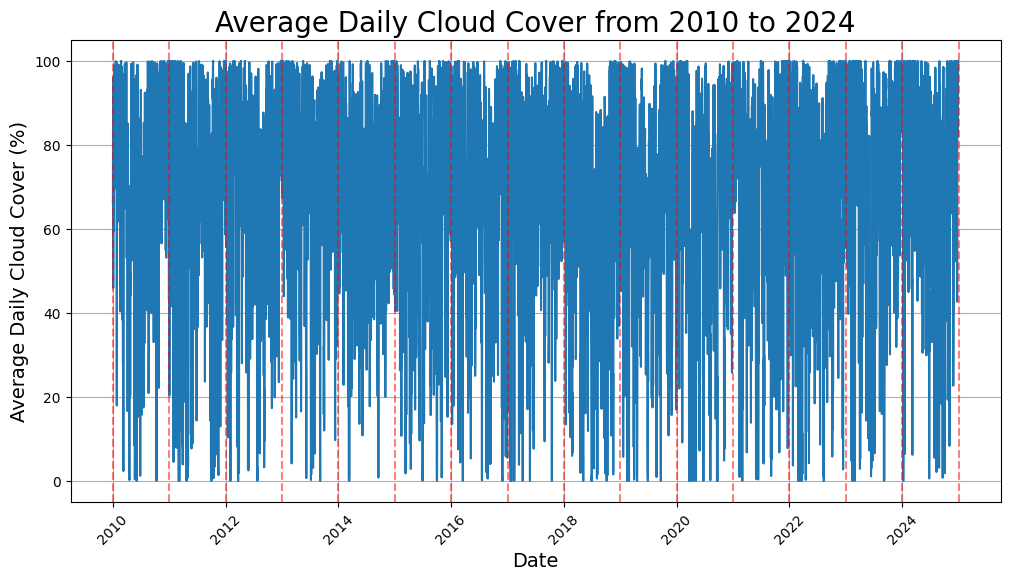

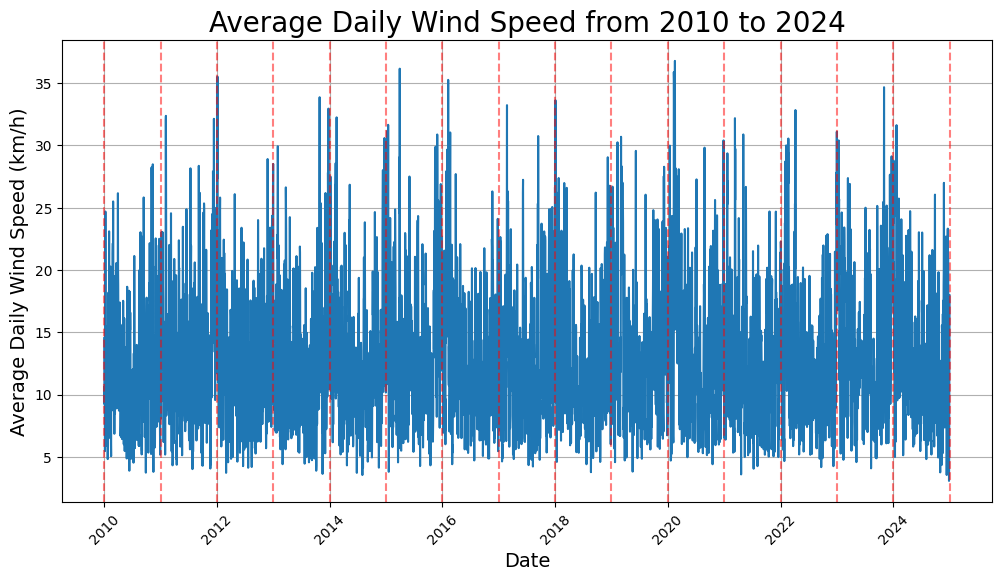

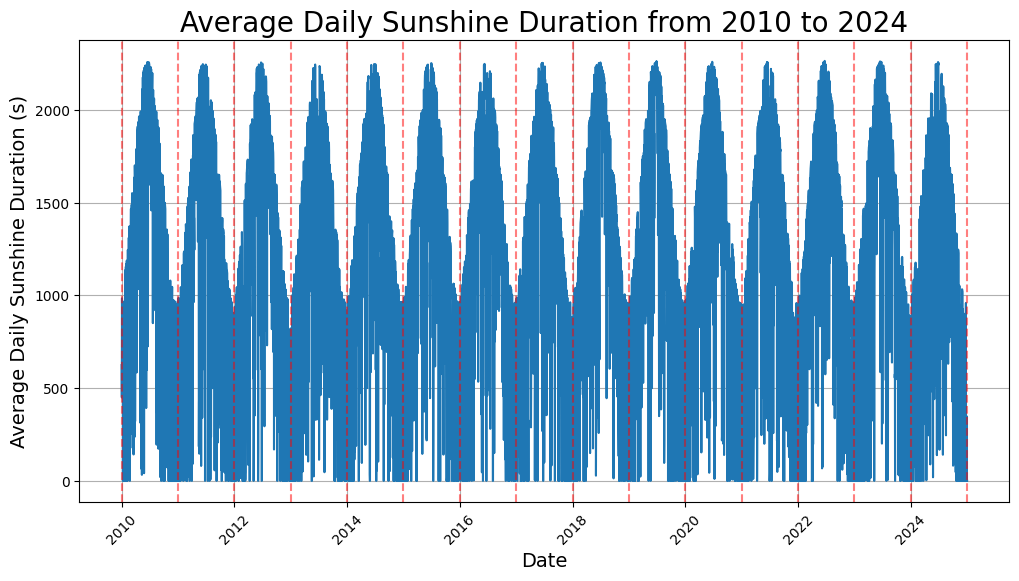

In [11]:
weather_var = ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']
def plot_average_weather_variable(weather_var, title, ylabel):
    """
    Plots the average weather variable over time.
    """
    average_daily = all_data.groupby(['year', 'month', 'day'])[weather_var].mean().reset_index()
    average_daily['date'] = pd.to_datetime(
        average_daily[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    average_daily = average_daily.sort_values(by='date')
    plt.figure(figsize=(12, 6))
    plt.plot(average_daily['date'], average_daily[weather_var])
    plt.xlabel('Date', size=14)
    plt.ylabel(ylabel, size=14)
    plt.title(title, size =20)
    plt.xticks(rotation=45)
    # add lines for each year
    for year in range(2010, 2026):
        plt.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', alpha=0.5)


    plt.grid()
    plt.show()
plot_average_weather_variable('temp', title = 'Average Daily Temperature from 2010 to 2024', ylabel = 'Average Daily Temperature (°C)')
plot_average_weather_variable('precip', title = 'Average Daily Precipitation from 2010 to 2024', ylabel = 'Average Daily Precipitation (mm)')
plot_average_weather_variable('cloud_cover', title = 'Average Daily Cloud Cover from 2010 to 2024', ylabel = 'Average Daily Cloud Cover (%)')
plot_average_weather_variable('wind_speed', title = 'Average Daily Wind Speed from 2010 to 2024', ylabel = 'Average Daily Wind Speed (km/h)')   
plot_average_weather_variable('sunshine', title = 'Average Daily Sunshine Duration from 2010 to 2024', ylabel = 'Average Daily Sunshine Duration (s)')


### Categorize Weather Variables

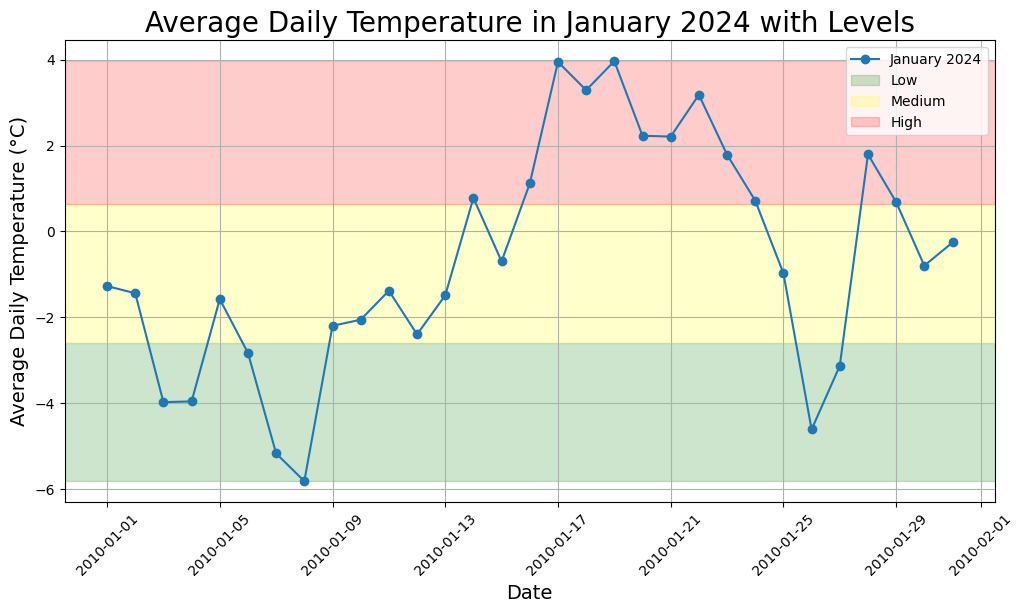

In [12]:
def average_daily(df, weather_var):
    """
    Calculates the average daily weather variable.
    """
    average_daily = df.groupby(['year', 'month', 'day'])[weather_var].mean().reset_index()
    average_daily['date'] = pd.to_datetime(
        average_daily[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
    return average_daily
# Filter data for January 2024

average_daily_temp = average_daily(all_data, 'temp')
january_2024 = average_daily_temp[
    (average_daily_temp['year'] == 2010) & (average_daily_temp['month'] == 1)
]

# Define thresholds for low, medium, and high levels
low_threshold = january_2024['temp'].min() + (january_2024['temp'].max() - january_2024['temp'].min()) * 0.33
high_threshold = january_2024['temp'].min() + (january_2024['temp'].max() - january_2024['temp'].min()) * 0.66

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(january_2024['date'], january_2024['temp'], marker='o', label='January 2024')

# Add horizontal bands for low, medium, and high levels
plt.axhspan(january_2024['temp'].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, january_2024['temp'].max(), color='red', alpha=0.2, label='High')

# Add labels and title
plt.xlabel('Date', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January 2024 with Levels', size=20)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

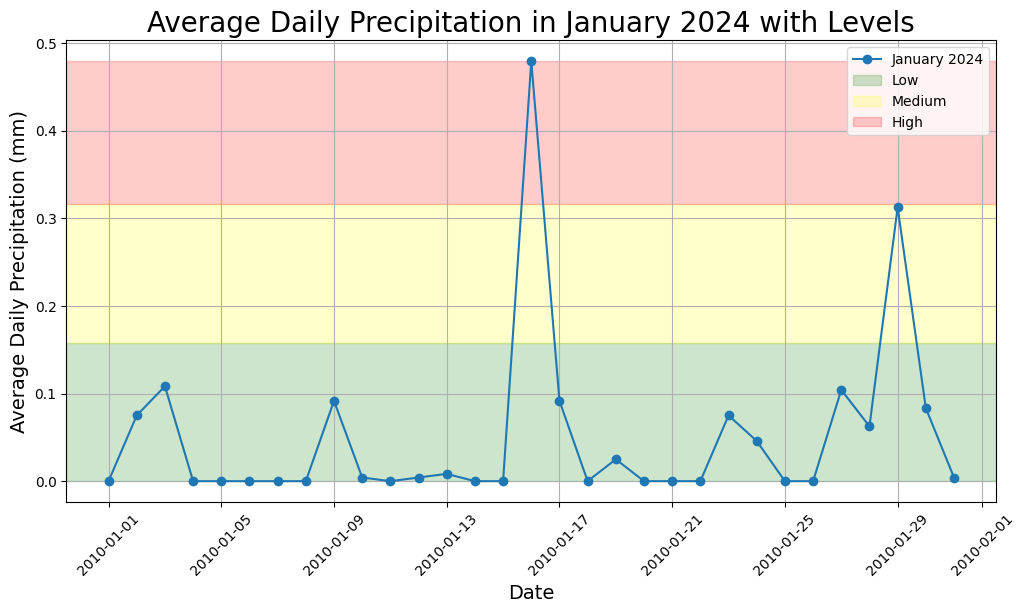

In [13]:

average_daily_temp = average_daily(all_data, 'precip')
january_2024 = average_daily_temp[
    (average_daily_temp['year'] == 2010) & (average_daily_temp['month'] == 1)
]

# Define thresholds for low, medium, and high levels
low_threshold = january_2024['precip'].min() + (january_2024['precip'].max() - january_2024['precip'].min()) * 0.33
high_threshold = january_2024['precip'].min() + (january_2024['precip'].max() - january_2024['precip'].min()) * 0.66

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(january_2024['date'], january_2024['precip'], marker='o', label='January 2024')

# Add horizontal bands for low, medium, and high levels
plt.axhspan(january_2024['precip'].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, january_2024['precip'].max(), color='red', alpha=0.2, label='High')

# Add labels and title
plt.xlabel('Date', size=14)
plt.ylabel('Average Daily Precipitation (mm)', size=14)
plt.title('Average Daily Precipitation in January 2024 with Levels', size=20)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

## Defining Weather States

#### Average the Data

In [14]:
daily_mean_df = all_data.groupby(['year', 'month', 'day']).mean().reset_index()



In [15]:
daily_mean_df

,year,month,day,time,temp,precip,weather_code,cloud_cover,wind_speed,sunshine,minute,second,hour,month_day_time
0,2010,1,1,2010-01-01 11:30:00,-1.275000,0.000000,4.833333,65.916667,14.529167,624.460417,0.0,0.0,11.5,2000-01-01 11:30:00
1,2010,1,2,2010-01-02 11:30:00,-1.441667,0.075000,25.666667,90.083333,11.879167,450.000000,0.0,0.0,11.5,2000-01-02 11:30:00
2,2010,1,3,2010-01-03 11:30:00,-3.979167,0.108333,18.750000,45.958333,9.233333,984.435833,0.0,0.0,11.5,2000-01-03 11:30:00
3,2010,1,4,2010-01-04 11:30:00,-3.962500,0.000000,2.958333,96.125000,10.220833,843.315417,0.0,0.0,11.5,2000-01-04 11:30:00
4,2010,1,5,2010-01-05 11:30:00,-1.579167,0.000000,3.000000,94.375000,10.658333,807.887500,0.0,0.0,11.5,2000-01-05 11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5474,2024,12,27,2024-12-27 11:30:00,1.170833,0.000000,2.708333,88.916667,3.066667,349.514167,0.0,0.0,11.5,2000-12-27 11:30:00
5475,2024,12,28,2024-12-28 11:30:00,-0.108333,0.000000,2.458333,82.041667,4.554167,203.588750,0.0,0.0,11.5,2000-12-28 11:30:00
5476,2024,12,29,2024-12-29 11:30:00,1.937500,0.000000,3.000000,100.000000,10.829167,0.000000,0.0,0.0,11.5,2000-12-29 11:30:00
5477,2024,12,30,2024-12-30 11:30:00,4.366667,0.000000,3.000000,100.000000,14.758333,0.000000,0.0,0.0,11.5,2000-12-30 11:30:00


#### Calculate Monthly Percentiles

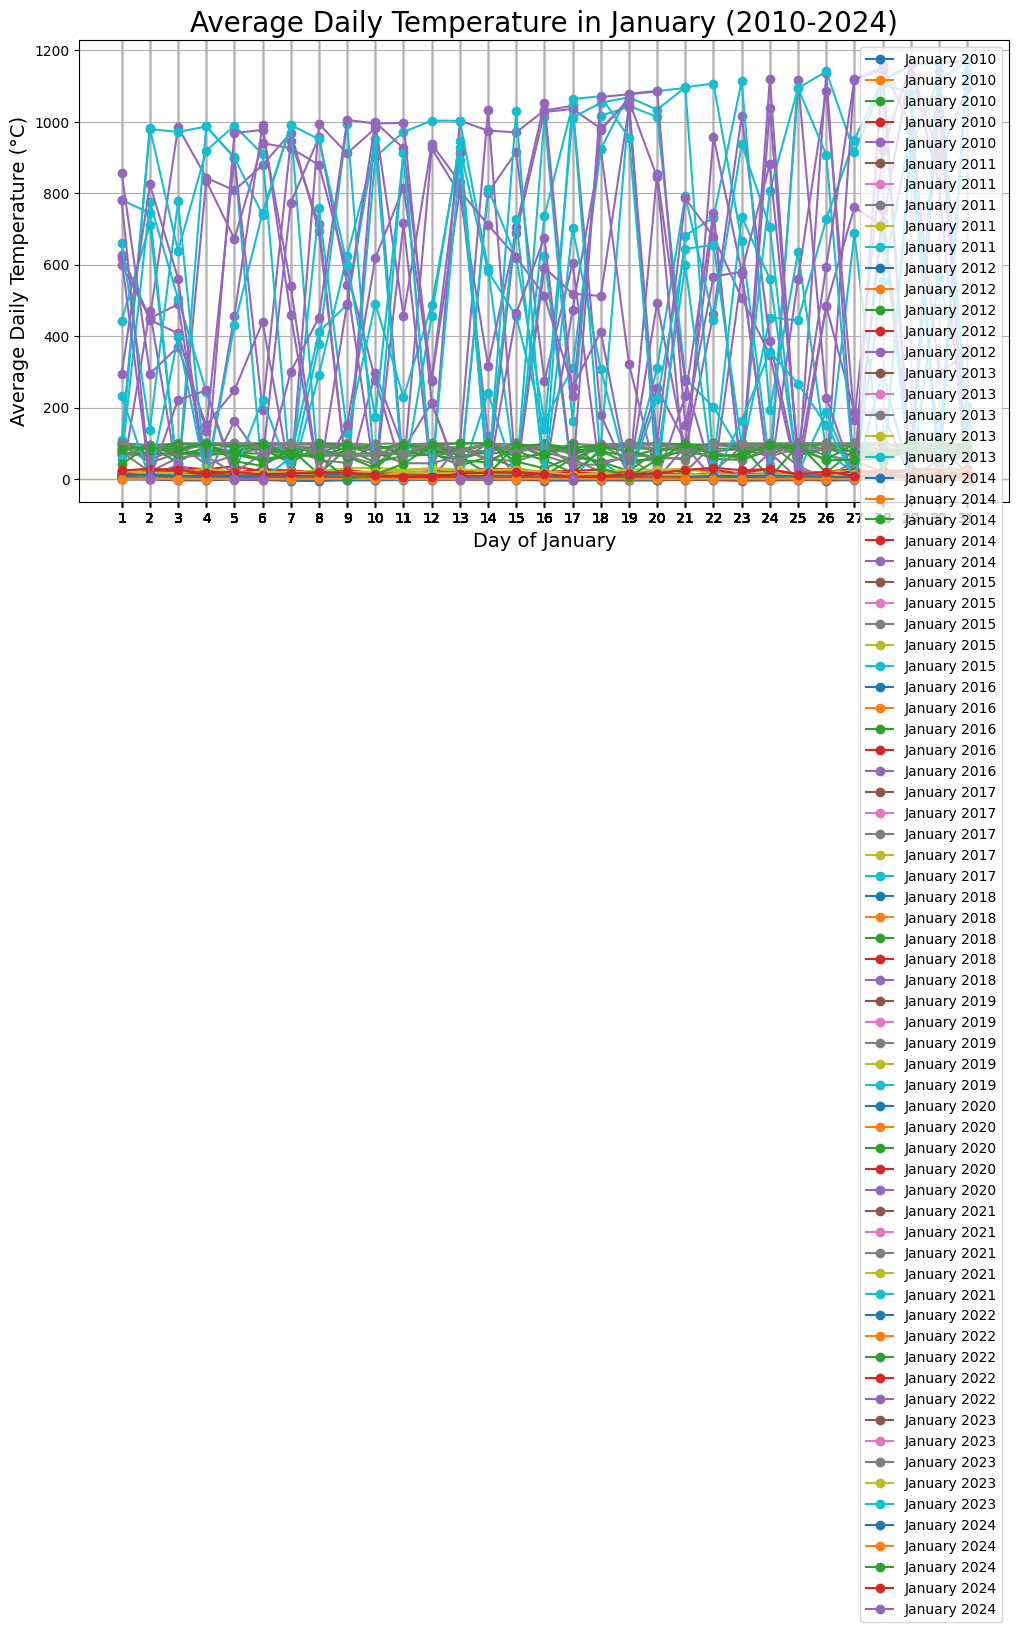

In [16]:
month_data = daily_mean_df[daily_mean_df['month'] == 1]

plt.figure(figsize=(12, 6))
# Plot lines for each year 
for year in range(2010, 2025):
    year_data = month_data[month_data['year'] == year]
    plt.plot(year_data['day'], year_data[weather_var], marker='o', label=f'January {year}')
plt.xlabel('Day of January', size=14)
plt.ylabel('Average Daily Temperature (°C)', size=14)
plt.title('Average Daily Temperature in January (2010-2024)', size=20)
plt.xticks(month_data['day'])
plt.grid()
plt.legend()

weather_var = 'precip'
# Define thresholds for low, medium, and high levels
low_threshold = month_data[weather_var].min() + (month_data[weather_var].max() - month_data[weather_var].min()) * 0.33
high_threshold = month_data[weather_var].min() + (month_data[weather_var].max() - month_data[weather_var].min()) * 0.66

# Add horizontal bands for low, medium, and high levels
plt.axhspan(month_data[weather_var].min(), low_threshold, color='green', alpha=0.2, label='Low')
plt.axhspan(low_threshold, high_threshold, color='yellow', alpha=0.2, label='Medium')
plt.axhspan(high_threshold, month_data[weather_var].max(), color='red', alpha=0.2, label='High')


plt.show()

In [17]:
month_data 

,year,month,day,time,temp,precip,weather_code,cloud_cover,wind_speed,sunshine,minute,second,hour,month_day_time
0,2010,1,1,2010-01-01 11:30:00,-1.275000,0.000000,4.833333,65.916667,14.529167,624.460417,0.0,0.0,11.5,2000-01-01 11:30:00
1,2010,1,2,2010-01-02 11:30:00,-1.441667,0.075000,25.666667,90.083333,11.879167,450.000000,0.0,0.0,11.5,2000-01-02 11:30:00
2,2010,1,3,2010-01-03 11:30:00,-3.979167,0.108333,18.750000,45.958333,9.233333,984.435833,0.0,0.0,11.5,2000-01-03 11:30:00
3,2010,1,4,2010-01-04 11:30:00,-3.962500,0.000000,2.958333,96.125000,10.220833,843.315417,0.0,0.0,11.5,2000-01-04 11:30:00
4,2010,1,5,2010-01-05 11:30:00,-1.579167,0.000000,3.000000,94.375000,10.658333,807.887500,0.0,0.0,11.5,2000-01-05 11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5139,2024,1,27,2024-01-27 11:30:00,2.416667,0.000000,1.625000,53.583333,9.537500,1118.418333,0.0,0.0,11.5,2000-01-27 11:30:00
5140,2024,1,28,2024-01-28 11:30:00,3.654167,0.000000,1.791667,59.125000,10.462500,1152.299167,0.0,0.0,11.5,2000-01-28 11:30:00
5141,2024,1,29,2024-01-29 11:30:00,7.491667,0.000000,2.875000,93.916667,11.233333,989.514167,0.0,0.0,11.5,2000-01-29 11:30:00
5142,2024,1,30,2024-01-30 11:30:00,8.870833,0.004167,5.000000,99.000000,15.991667,300.000000,0.0,0.0,11.5,2000-01-30 11:30:00


In [18]:
def calculate_percentiles_and_categorize(df, month):
    """
    Calculates percentiles for a specific month and categorizes weather variables into low, medium, and high.
    Includes zero precipitation values in the "Low" category.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing weather data.
        month (int): The month for which to calculate percentiles (1 = January, ..., 12 = December).

    Returns:
        pd.DataFrame: A new DataFrame with additional columns for categorized weather variables.
    """
    # Filter data for the specified month
    month_data = df[df['month'] == month].copy()

    # Calculate percentiles for each weather variable
    thresholds = {}
    for variable in ['temp', 'precip', 'cloud_cover', 'wind_speed', 'sunshine']:
        variable_data = month_data[variable].dropna()

        if variable == 'precip':
            # Include zero values in the "Low" category
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}
        else:
            # Standard percentile calculation
            low = np.percentile(variable_data, 33)
            high = np.percentile(variable_data, 66)
            thresholds[variable] = {'low': low, 'high': high}

    # Categorize each variable based on the calculated thresholds
    for variable in thresholds.keys():
        low, high = thresholds[variable]['low'], thresholds[variable]['high']
        month_data[f'{variable}_category'] = month_data[variable].apply(
            lambda x: 'Low' if x <= low else 'Medium' if x < high else 'High'
        )

    return month_data

#### Combine Weather Categories into Weather States
Thus each state has n amount of weather categories. \
**There will be different experimental setups:**
1) 2 variables - Temperature and Precipitation
2) 5 variables - Temperature, Precipitation, Wind Speed, Cloud Cover, Sunshine Duration

In [19]:
df_states1 = calculate_percentiles_and_categorize(month_data, 1)

In [20]:
df_sates1 = df_states1[['year', 'month', 'day', 'temp_category', 'precip_category', 'cloud_cover_category', 'wind_speed_category', 'sunshine_category']]

In [21]:
# 1st Experiment - 2 variables - Temperature and Precipitation
# combine categories into 2 variable state
df_states1['state1'] = df_states1[['temp_category', 'precip_category']].agg('-'.join, axis=1)

In [22]:
print(df_states1['precip_category'].unique())
print(df_states1['temp_category'].unique())

['Low' 'Medium' 'High']
['Low' 'Medium' 'High']


In [29]:
# make df_states1 a csv file
df_states1.to_csv('data/df_states1.csv', index=False)

In [24]:
df_states1['state1'].unique()

array(['Low-Low', 'Low-Medium', 'Low-High', 'Medium-High', 'Medium-Low',
       'Medium-Medium', 'High-High', 'High-Medium', 'High-Low'],
      dtype=object)

#### Creating Transition Matrix 

In [39]:
df = df_states1[['state1','next_state']].copy()
df.head(30)

,state1,next_state
0,Low-Low,Low-Medium
1,Low-Medium,Low-High
2,Low-High,Low-Low
3,Low-Low,Low-Low
4,Low-Low,Low-Low
5,Low-Low,Low-Low
6,Low-Low,Low-Low
7,Low-Low,Low-High
8,Low-High,Low-Medium
9,Low-Medium,Low-Low


In [41]:
all_states = sorted(set(df['state1'].unique()) | set(df['next_state'].unique()))
num_states = len(all_states)
print(f"\nAll unique states: {all_states}")
print(f"Number of states: {num_states}")


All unique states: ['High-High', 'High-Low', 'High-Medium', 'Low-High', 'Low-Low', 'Low-Medium', 'Medium-High', 'Medium-Low', 'Medium-Medium']
Number of states: 9


# ------

In [52]:
# Define the next state
df['next_state'] = df['state1'].shift(-1)
# Drop the last row since it has no next state
df = df.dropna(subset=['next_state'])
# Create a transition matrix with raw counts
transition_counts = pd.crosstab(df['state1'], df['next_state'])


In [53]:
# count amounts of states in the state1 column
state_counts = df_states1['state1'].value_counts()
next_state_counts = df_states1['next_state'].value_counts()

print(state_counts, next_state_counts)

state1
High-High        91
Low-Low          90
Medium-Medium    60
Medium-High      49
Medium-Low       44
High-Medium      42
Low-Medium       36
Low-High         28
High-Low         24
Name: count, dtype: int64 next_state
High-High        91
Low-Low          89
Medium-Medium    60
Medium-High      49
Medium-Low       44
High-Medium      42
Low-Medium       36
Low-High         28
High-Low         25
Name: count, dtype: int64


In [54]:
print(transition_counts)

next_state     High-High  High-Low  High-Medium  Low-High  Low-Low  \
state1                                                               
High-High             40         6           18         0        0   
High-Low               8         6            6         0        0   
High-Medium           16         3            8         0        0   
Low-High               0         1            0         5        7   
Low-Low                3         1            1        10       52   
Low-Medium             1         2            1         5       17   
Medium-High            7         0            2         5        3   
Medium-Low             8         1            3         0        7   
Medium-Medium          8         3            2         3        3   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High               2            8           4             13  
High-Low                0

In [55]:
# Normalize the transition counts to calculate probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# Fill NaN values with 0 (in case some rows have no transitions)
transition_matrix = transition_matrix.fillna(0)
# Print the transition matrix
print(transition_matrix)

next_state     High-High  High-Low  High-Medium  Low-High   Low-Low  \
state1                                                                
High-High       0.439560  0.065934     0.197802  0.000000  0.000000   
High-Low        0.347826  0.260870     0.260870  0.000000  0.000000   
High-Medium     0.390244  0.073171     0.195122  0.000000  0.000000   
Low-High        0.000000  0.035714     0.000000  0.178571  0.250000   
Low-Low         0.033333  0.011111     0.011111  0.111111  0.577778   
Low-Medium      0.027778  0.055556     0.027778  0.138889  0.472222   
Medium-High     0.142857  0.000000     0.040816  0.102041  0.061224   
Medium-Low      0.186047  0.023256     0.069767  0.000000  0.162791   
Medium-Medium   0.133333  0.050000     0.033333  0.050000  0.050000   

next_state     Low-Medium  Medium-High  Medium-Low  Medium-Medium  
state1                                                             
High-High        0.021978     0.087912    0.043956       0.142857  
High-Low      

In [56]:
# Verify that rows sum to 1
row_sums = transition_matrix.sum(axis=1)
print("Row sums (should all be 1):")
print(row_sums)

Row sums (should all be 1):
state1
High-High        1.0
High-Low         1.0
High-Medium      1.0
Low-High         1.0
Low-Low          1.0
Low-Medium       1.0
Medium-High      1.0
Medium-Low       1.0
Medium-Medium    1.0
dtype: float64


## Markov Chain Implementation 

In [57]:
# defining markov chain implementation function

def simulate_markov_chain(transition_matrix, states, initial_state, steps):
    '''
    Simulates a Markov Chain
    '''
    # initialise current state
    current_state = initial_state 
    # add current state to the list of sequences 
    state_sequence = [current_state]

    # generate n steps of states 
    for _ in range(steps): 
        # get probability for the current state
        probabilities = transition_matrix.loc[current_state].values
        # choose the next state based on the probabilities 
        next_state = np.random.choice(states, p=probabilities)
        state_sequence.append(next_state)
        current_state = next_state

    return state_sequence

    


In [66]:
# List of all states
all_states = transition_matrix.index.tolist()

# Initial state (choose one from the list of states)
initial_state = np.random.choice(all_states) 

# Number of steps to simulate
steps = 31

# Simulate the Markov Chain
state_sequence = simulate_markov_chain(transition_matrix, all_states, initial_state, steps)

# Print the simulated sequence
print("Simulated State Sequence:")
print(state_sequence)

Simulated State Sequence:
[np.str_('High-Low'), np.str_('High-High'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('Medium-Medium'), np.str_('Medium-Medium'), np.str_('Low-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('High-Medium'), np.str_('High-High'), np.str_('Low-Medium'), np.str_('Low-Medium'), np.str_('Low-Medium'), np.str_('Medium-Medium'), np.str_('Medium-Low'), np.str_('High-Medium'), np.str_('High-High'), np.str_('Medium-Medium'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('Low-Low'), np.str_('High-Low'), np.str_('High-High'), np.str_('High-Medium'), np.str_('High-Low'), np.str_('High-Low'), np.str_('Medium-Low'), np.str_('Low-Low'), np.str_('Low-High')]


In [68]:
# Convert np.str_ objects to regular Python strings
string_list = [str(item) for item in state_sequence]
string_list

['High-Low',
 'High-High',
 'Medium-Medium',
 'Medium-Low',
 'Medium-Medium',
 'Medium-Medium',
 'Low-Medium',
 'Low-Low',
 'Low-Low',
 'High-Medium',
 'High-High',
 'Low-Medium',
 'Low-Medium',
 'Low-Medium',
 'Medium-Medium',
 'Medium-Low',
 'High-Medium',
 'High-High',
 'Medium-Medium',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'Low-Low',
 'High-Low',
 'High-High',
 'High-Medium',
 'High-Low',
 'High-Low',
 'Medium-Low',
 'Low-Low',
 'Low-High']

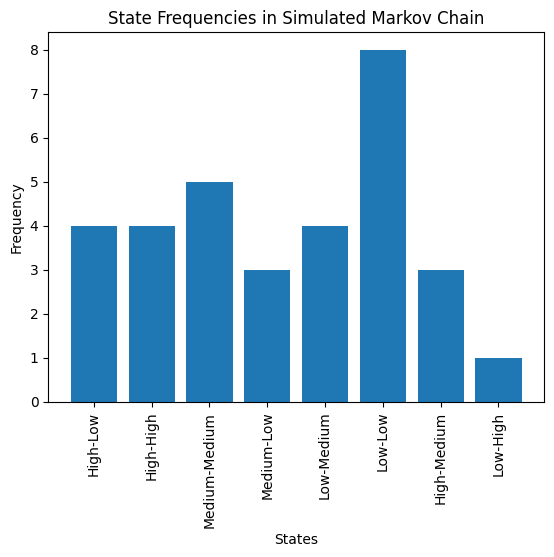

In [67]:
import matplotlib.pyplot as plt

# Count the frequency of each state
from collections import Counter
state_counts = Counter(state_sequence)

# Plot the state frequencies
plt.bar(state_counts.keys(), state_counts.values())
plt.xlabel('States')
plt.ylabel('Frequency')
plt.title('State Frequencies in Simulated Markov Chain')
plt.xticks(rotation=90)
plt.show()